# VS Ensemble Dockig CDK2
## Análisis de datos exploratorio

- 111 ligandos
    - 27 Activos
- 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales
- 3 progrmas de acoplamiento molecular

In [1]:
import pandas as pd 
import numpy as np 

### Carga de los datos

In [3]:
# Directorio
data_dir = './B_DATOS'
# Carga de los dataFrames
# Autodock 4. LE (lowest energy), LC (largest Cluster)
df_ad4_results_LE = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_AD4_LE.csv', index_col=0)
df_ad4_results_LC = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_AD4_LC.csv', index_col=0)
# Autodock Vina
df_vina_results = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_VINA.csv', index_col=0)
# Vinardo scoring
df_vinardo_results = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_VINARDO.csv', index_col=0)

In [13]:
# Vinardo scoring exh 8
df_vinardo_results_ex8 = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_VINARDO_ex8.csv', index_col=0)

In [5]:
for df in [df_ad4_results_LE, df_ad4_results_LC, df_vina_results, df_vinardo_results, df_vinardo_results_ex8]:
    print(df.shape)

(111, 403)
(111, 403)
(111, 403)
(111, 403)
(111, 403)


Todas los dataFrames poseen 111 filas (111 ligandos) y 403 columnas, correspondientes a la etiqueta de actividad/inactividad, y a las 402 conformaciones. 

### Datos CDK2 de CSAR
Las etiquetas de actividad y la información sobre los 111 ligandos se encuentran en el siguiente [enlace](https://drugdesigndata.org/about/datasets/220).

### Comenzamos el análisis de los datos

In [6]:
# Identificamos a los ligandos que son activos
activos =  df_vina_results.ActiveInactive == "Active"

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Definimos una función para graficar boxplots
def plot_boxplot_dock_results(df, titulo=''):
    '''Función para graficar boxplots de los resultados de acoplamiento molecular'''
    num_ligs, num_conf = df.iloc[:, 2:-1].shape
    fig, ax = plt.subplots(figsize =(20, 5))
    sns.set_style("white"); sns.set_context("paper")
    ax.axvspan(0, 3, color=sns.xkcd_rgb['grey'], alpha=0.3)
    ax.axvspan(5, 16, color=sns.xkcd_rgb['grey'], alpha=0.3)
    ax.axvspan(101, 110, color=sns.xkcd_rgb['grey'], alpha=0.3)
    sns.boxplot(ax = ax,  data = df.iloc[:, 2:-1].T )
    plt.title(F"{titulo}: Boxplots - {num_ligs} ligandos - {num_conf} conformaciones", size = 20)
    plt.xticks(rotation=90, size=11)
    ax.set_ylabel(F'{titulo} Score (kcal/mol)', fontsize=18)
    ax.set_xlabel('Ligandos CSAR', fontsize=18)
    plt.show()

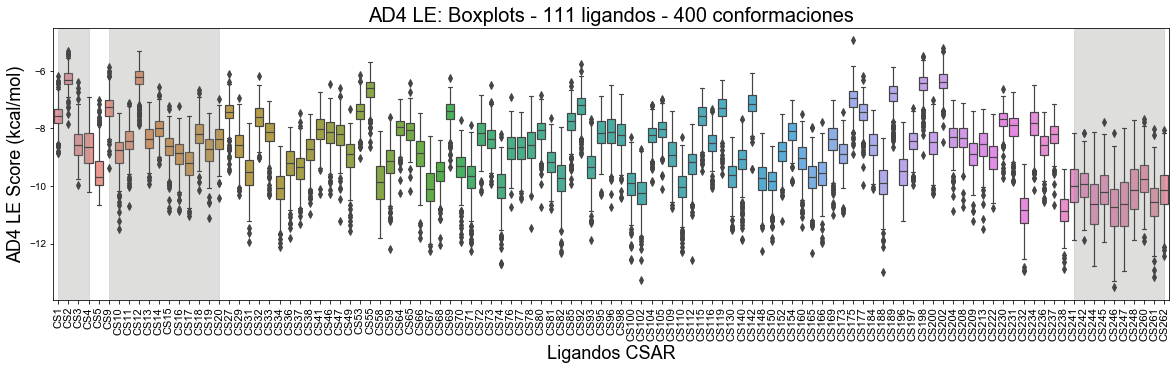

In [7]:
plot_boxplot_dock_results(df_ad4_results_LE, titulo="AD4 LE")

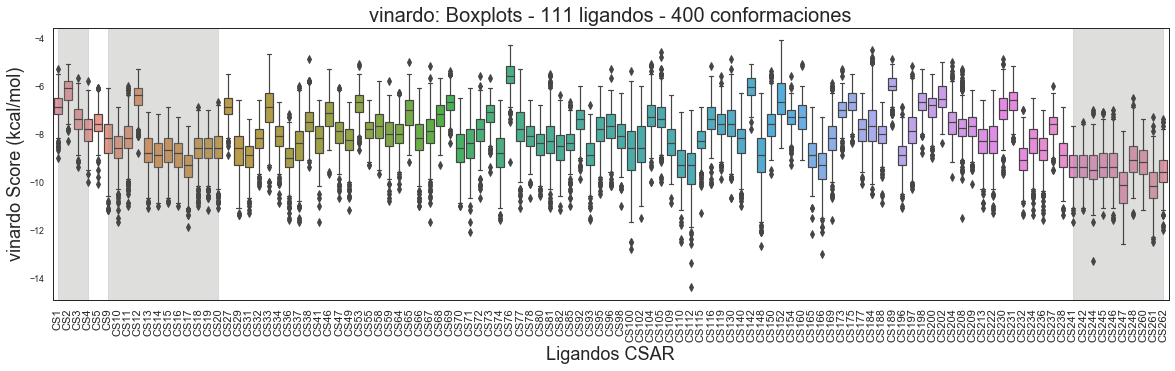

In [8]:
plot_boxplot_dock_results(df_vinardo_results, titulo="vinardo")

En cada gráfica, se muestran los 111 ligandos y sus scores para cada una de las 402 conformaciones de la proteína.

## Curvas ROC

In [8]:
# Librerías para calcular las ROC y el AUC
from sklearn.metrics import roc_curve, roc_auc_score

Etiquetas de los ligandos, **1 = Activo**.

In [9]:
true_values = np.array(df_vina_results.ActiveInactive == "Active", dtype=int)
print(true_values)

[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


Calculamos el **AUC** tomando en cuenta los *rankings* de cada programa de *docking* a partir del promedio de los ranking por conformación.

In [15]:
sc_promedio_vrd = np.array(df_vinardo_results.mean(axis=1))
sc_promedio_vina = np.array(df_vina_results.mean(axis=1))
sc_promedio_ad4_LE = np.array(df_ad4_results_LE.mean(axis=1))
sc_promedio_ad4_LC = np.array(df_ad4_results_LC.mean(axis=1))
# Vinardo 8x
sc_promedio_vrd_8x = np.array(df_vinardo_results_ex8.mean(axis=1))

**Curvas ROC:**

In [16]:
print('AUC del valor PROMEDIO (402 estructuras):')
print("AD4 LE:", 
        roc_auc_score( y_true = true_values, y_score = (- sc_promedio_ad4_LE)) )        
print("AD4 LC:", 
        roc_auc_score( y_true = true_values, y_score = (- sc_promedio_ad4_LC)) )
print("Vina 16x:", 
        roc_auc_score( y_true = true_values, y_score = (- sc_promedio_vina)) )
print("Vinardo 16x:", 
        roc_auc_score( y_true = true_values, y_score = (- sc_promedio_vrd)) )   
print("Vinardo 8x:", 
        roc_auc_score( y_true = true_values, y_score = (- sc_promedio_vrd_8x)) )   

AUC del valor PROMEDIO (402 estructuras):
AD4 LE: 0.5941176470588236
AD4 LC: 0.6900452488687783
Vina 16x: 0.5524886877828055
Vinardo 16x: 0.7610859728506787
Vinardo 8x: 0.7656108597285067


**Gráficas de las ROC.**

In [20]:
# Establecemos los parámetros para graficar
import pylab
pylab.rcParams['figure.figsize'] = (7, 7)
sns.set( context = 'talk', style = 'white', palette = "Set2")

def add_plot_roc(predicted_values, true_values, label):
    inverted_input = np.negative(predicted_values)
    fpr, tpr, thresholds = roc_curve(true_values, inverted_input)
    auc = roc_auc_score( y_true = true_values, y_score = inverted_input)
    plt.plot(fpr, tpr, label= label + ' AUC = %0.2f' % auc, lw = 4)

def plot_roc(predicted_values, true_values, label, titulo = "ROC curve"):
    sns.color_palette("Paired")
    add_plot_roc(predicted_values, true_values, label)
    plt.legend()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("FPR (1 - specificity)")
    plt.ylabel("TPR (sensitivity)")
    plt.grid(linestyle='--', linewidth='0.8')
    plt.title(titulo)
    plt.show()

### ROC con valores promedio
Gráfica **ROC** con valores promedio.

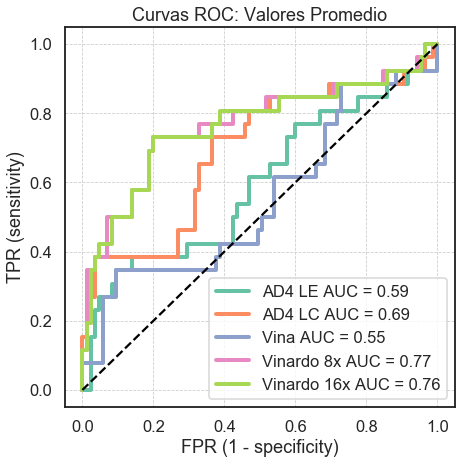

In [21]:
add_plot_roc(sc_promedio_ad4_LE, true_values, "AD4 LE")
add_plot_roc(sc_promedio_ad4_LC, true_values, "AD4 LC")
add_plot_roc(sc_promedio_vina, true_values, "Vina")
add_plot_roc(sc_promedio_vrd_8x, true_values, "Vinardo 8x")
plot_roc(sc_promedio_vrd, true_values, "Vinardo 16x", "Curvas ROC: Valores Promedio")

### ROC con mejores *scores*
Gráficas **ROC**, si para el **ranking** final extrajeramos el mejor score de cada ligando.

In [22]:
# Scorings mínimos (mejores) de cada ligando
sc_minimo_vrd = np.array(df_vinardo_results.min(axis=1))
sc_minimo_vrd_8x = np.array(df_vinardo_results_ex8.min(axis=1))
sc_minimo_vina = np.array(df_vina_results.min(axis=1))
sc_minimo_ad4_LE = np.array(df_ad4_results_LE.min(axis=1))
sc_minimo_ad4_LC = np.array(df_ad4_results_LC.min(axis=1))

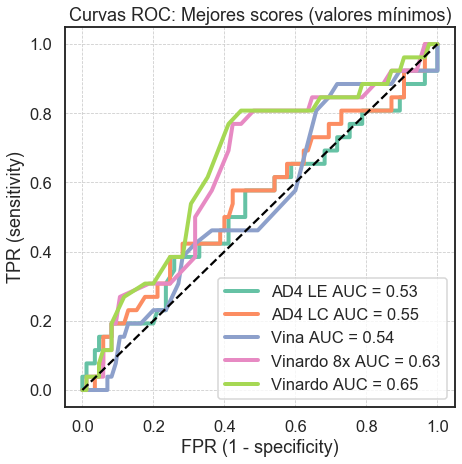

In [23]:
add_plot_roc(sc_minimo_ad4_LE, true_values, "AD4 LE")
add_plot_roc(sc_minimo_ad4_LC, true_values, "AD4 LC")
add_plot_roc(sc_minimo_vina, true_values, "Vina")
add_plot_roc(sc_minimo_vrd_8x, true_values, "Vinardo 8x")
plot_roc(sc_minimo_vrd, true_values, "Vinardo", "Curvas ROC: Mejores scores (valores mínimos)")

### ROC con *ranking* de una conformación
Curva ROC a partir del *ranking* de una conformación dada: "**1aq1**"

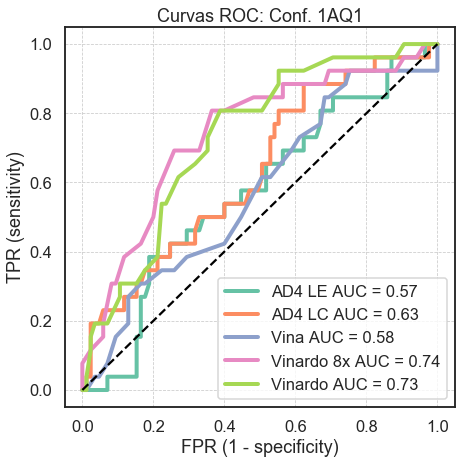

   Umbrales       FPR       TPR
0     11.83  0.000000  0.000000
1     10.83  0.011765  0.000000
2     10.78  0.011765  0.038462
3     10.58  0.023529  0.038462
4      9.95  0.023529  0.192308
5      9.73  0.047059  0.192308
6      9.62  0.058824  0.230769
7      9.39  0.117647  0.230769
8      9.17  0.117647  0.269231
9      9.08  0.152941  0.269231
Número de umbrales: 52
Ligando                      CS238   CS246      CS58   CS247   CS248   CS244  \
Pos. Etiquetas Predichas  Inactive  Active  Inactive  Active  Active  Active   
Scores                       10.83   10.78     10.58   10.19   10.14   10.01   

Ligando                    CS245      CS74      CS67   CS262  ...      CS47  \
Pos. Etiquetas Predichas  Active  Inactive  Inactive  Active  ...  Inactive   
Scores                      9.95      9.93      9.73    9.62  ...      6.53   

Ligando                      CS198     CS177      CS72      CS32     CS189  \
Pos. Etiquetas Predichas  Inactive  Inactive  Inactive  Inactive  In

In [25]:
# Curva ROC dada una conformación
pdb_id = "1aq1"
add_plot_roc(df_ad4_results_LE[ pdb_id ], true_values, "AD4 LE")
add_plot_roc(df_ad4_results_LC[ pdb_id ], true_values, "AD4 LC")
add_plot_roc(df_vina_results[ pdb_id ], true_values, "Vina")
add_plot_roc(df_vinardo_results_ex8[ pdb_id ], true_values, "Vinardo 8x")
plot_roc(df_vinardo_results[ pdb_id ], true_values, "Vinardo", F"Curvas ROC: Conf. {pdb_id.upper()}")

# Entendiendo la curva ROC

# Los scores de vina y vinardo parecen estar más suavizados debido a que sus scores
# sólo tienen décimas y no centésimas, lo que hace más porbable que diferentes ligandos
# puedan tener el mismo score, esto repercute en el número de umbrales, que es más 
# reducido en comparación con AD4, lo que aumenta el número de observaciones por umbral
df = df_ad4_results_LC
valores_observados = np.array(- df[ pdb_id] )
# Para esta evalución es importante que las etiquetas true_values y los scores estén
# ordenados iguales, es decir, que correspondan al mismo ligando. Ya después la función
# roc_curve se encargará de ordenarlas
valores_observados_ordenados = np.array(- df.sort_values(by = pdb_id)[ pdb_id] )
pos_etiquetas_predichos = df.sort_values(by = pdb_id)["ActiveInactive"]

fpr, tpr, thresholds = roc_curve(true_values, valores_observados)
tabla_roc_ejemplo = pd.DataFrame({"Umbrales": thresholds,  "FPR": fpr, "TPR": tpr})
print(tabla_roc_ejemplo.head(10))
print(F'Número de umbrales: {tabla_roc_ejemplo.shape[0]}')
print(pd.DataFrame({"Pos. Etiquetas Predichas": pos_etiquetas_predichos, 
                    "Scores": valores_observados_ordenados}).T)

## Calculamos el AUC para todas las conformarmaciones
Se realiza el cálculo del AUC de todas las conformaciones tomando en cuenta los 4 DataFrames de *scores* disponibles.

In [26]:
# Calculo del AUC por conformaión
# carga del dataFrame con la información general de las estructuras cristalográficas
df_cdk2_labels = pd.read_json(F"{data_dir}/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS.json")
df_cdk2_labels.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,Labels_conf
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.0,298,92.953020,2,"[8, 13]","[[36, 43], [149, 161]]",1,['STU'],STU,440.0,inact_b
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.0,298,97.315436,1,[8],"[[36, 43]]",3,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.1,298,97.315436,1,[8],"[[36, 43]]",3,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a


In [28]:
df_cdk2_labels["AUC_vrd_16x"] = 0.0
df_cdk2_labels["AUC_vrd_8x"] = 0.0
df_cdk2_labels["AUC_vina"] = 0.0
df_cdk2_labels["AUC_ad4_LC"] = 0.0
for pdb in df_cdk2_labels.index:
    # Vinardo 8x
    roc_vrd_8x = roc_auc_score(np.array(true_values), - df_vinardo_results_ex8[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_vrd_8x"] = roc_vrd_8x
    # Vinardo 16x
    roc_vrd = roc_auc_score(np.array(true_values), - df_vinardo_results[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_vrd_16x"] = roc_vrd
    # Vina 16x
    roc_vina = roc_auc_score(np.array(true_values), - df_vina_results[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_vina"] = roc_vina
    # Autodock 4: LE
    roc_ad4_LE = roc_auc_score(np.array(true_values), - df_ad4_results_LE[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_ad4_LE"] = roc_ad4_LE
    # Autodock 4: LC
    roc_ad4_LC = roc_auc_score(np.array(true_values), - df_ad4_results_LC[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_ad4_LC"] = roc_ad4_LC
df_cdk2_labels.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,Labels_conf,AUC_vrd_16x,AUC_vrd_8x,AUC_vina,AUC_ad4_LC,AUC_ad4_LE
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.0,298,92.953020,2,"[8, 13]","[[36, 43], [149, 161]]",1,['STU'],STU,440.0,inact_b,0.730317,0.740724,0.575339,0.634163,0.572172
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.0,298,97.315436,1,[8],"[[36, 43]]",3,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a,0.677828,0.683258,0.546154,0.571946,0.483032
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.1,298,97.315436,1,[8],"[[36, 43]]",3,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a,0.764706,0.785520,0.580543,0.670814,0.607919


In [20]:
# Guardamos el dataframe
# df_cdk2_labels.to_json(F"{data_dir}/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS_AUC_docking.json")

### ROC con *ranking* de la MEJOR conformación en Vinardo a 16x
Curva ROC a partir del *ranking* de la mejor conformación con Vinardo (conformación con mejor AUC de vinardo).

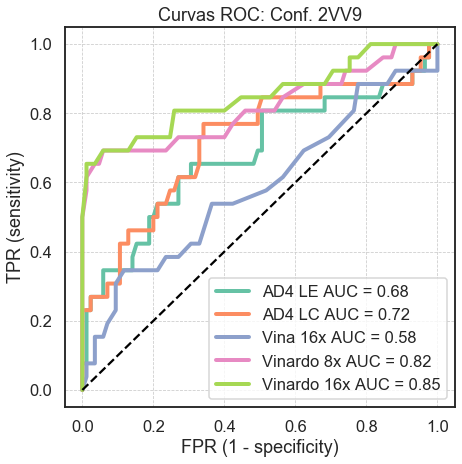

In [30]:
# ROC de la mejor conformación de vinardo
pdb_id = df_cdk2_labels[["AUC_vrd_16x"]].idxmax()[0]

add_plot_roc(df_ad4_results_LE[ pdb_id ], true_values, "AD4 LE")
add_plot_roc(df_ad4_results_LC[ pdb_id ], true_values, "AD4 LC")
add_plot_roc(df_vina_results[ pdb_id ], true_values, "Vina 16x")
add_plot_roc(df_vinardo_results_ex8[ pdb_id ], true_values, "Vinardo 8x")
plot_roc(df_vinardo_results[ pdb_id ], true_values, "Vinardo 16x", F"Curvas ROC: Conf. {pdb_id.upper()}")

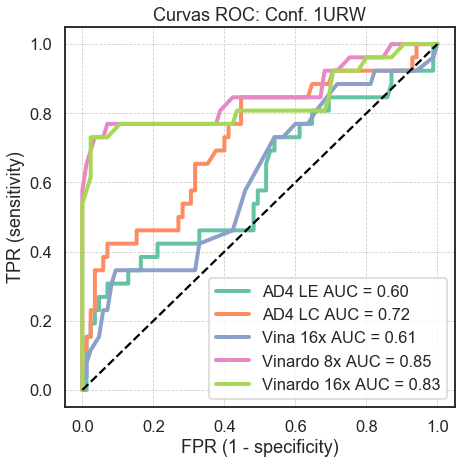

In [31]:
# ROC de la mejor conformación de vinardo a 8x
pdb_id = df_cdk2_labels[["AUC_vrd_8x"]].idxmax()[0]

add_plot_roc(df_ad4_results_LE[ pdb_id ], true_values, "AD4 LE")
add_plot_roc(df_ad4_results_LC[ pdb_id ], true_values, "AD4 LC")
add_plot_roc(df_vina_results[ pdb_id ], true_values, "Vina 16x")
add_plot_roc(df_vinardo_results_ex8[ pdb_id ], true_values, "Vinardo 8x")
plot_roc(df_vinardo_results[ pdb_id ], true_values, "Vinardo 16x", F"Curvas ROC: Conf. {pdb_id.upper()}")

### Distribución de AUC por programa de *docking*
#### *Violin plots*

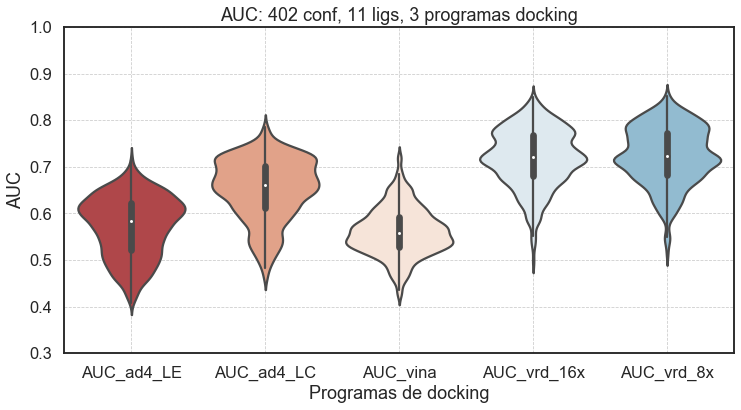

In [32]:
fig, axes = plt.subplots()
sns.set( context = 'talk', style = 'white', palette = "RdBu")
fig.set_size_inches(12, 6)
data = df_cdk2_labels[["AUC_ad4_LE", "AUC_ad4_LC", "AUC_vina", "AUC_vrd_16x", "AUC_vrd_8x"]]
sns.violinplot(data= data, ax = axes, bw=.2, split=True,
    scale="count")
#sns.swarmplot(data= data, ax = axes, color="black", alpha=0.3)
axes.set_title('AUC: 402 conf, 11 ligs, 3 programas docking')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

### Distribución de AUC por tipo de conformación

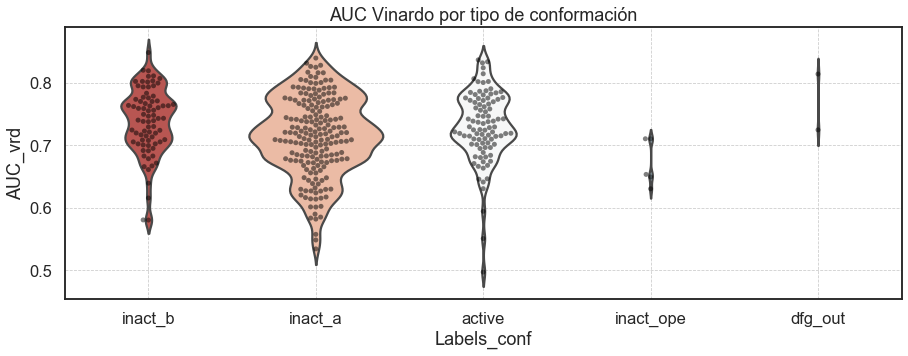

In [23]:
fig, axes = plt.subplots()
fig.set_size_inches(15, 5)
x_column = "Labels_conf"
y_column = "AUC_vrd"
df = df_cdk2_labels[df_cdk2_labels.Inhib != ""]
sns.violinplot(x= x_column, y= y_column, data= df, 
                ax = axes, palette="RdBu", bw=.2,  scale="count", inner=None)
sns.swarmplot(x=x_column, y= y_column, data= df, 
                ax = axes, color="black", alpha=0.5)
axes.set_title('AUC Vinardo por tipo de conformación')
axes.grid(linestyle='--', linewidth='0.8')
plt.show()

### Distribución de AUC: Inactivas vs Activas

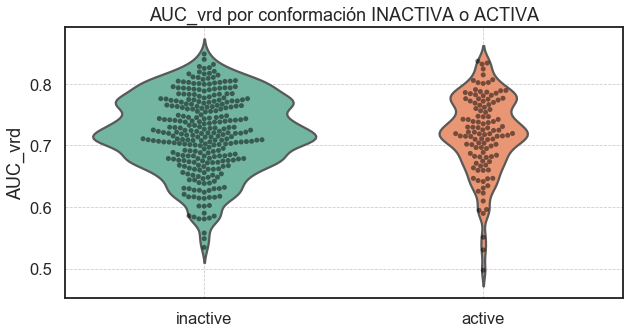

In [24]:
fig, axes = plt.subplots()
fig.set_size_inches(10, 5)
auc_docking = "AUC_vrd"
active_inactive_labels = [ "active" if i == "active" else "inactive" for i in df_cdk2_labels.Labels_conf]
sns.violinplot(x=active_inactive_labels, y=df_cdk2_labels[auc_docking], 
                ax = axes, bw=.2, scale="count", inner=None, palette= "Set2")
sns.swarmplot(x=active_inactive_labels, y=df_cdk2_labels[auc_docking], 
                ax = axes, color="black", alpha=0.5)
axes.set_title(F'{auc_docking} por conformación INACTIVA o ACTIVA')
axes.grid(linestyle='--', linewidth='0.8')
plt.show()